# ISLP - Chapter 8 - Exercise 11
### Author: pzuehlke

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
caravan = pd.read_csv("Caravan.csv")
caravan = caravan.dropna()
caravan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 86 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   MOSTYPE   5822 non-null   int64 
 1   MAANTHUI  5822 non-null   int64 
 2   MGEMOMV   5822 non-null   int64 
 3   MGEMLEEF  5822 non-null   int64 
 4   MOSHOOFD  5822 non-null   int64 
 5   MGODRK    5822 non-null   int64 
 6   MGODPR    5822 non-null   int64 
 7   MGODOV    5822 non-null   int64 
 8   MGODGE    5822 non-null   int64 
 9   MRELGE    5822 non-null   int64 
 10  MRELSA    5822 non-null   int64 
 11  MRELOV    5822 non-null   int64 
 12  MFALLEEN  5822 non-null   int64 
 13  MFGEKIND  5822 non-null   int64 
 14  MFWEKIND  5822 non-null   int64 
 15  MOPLHOOG  5822 non-null   int64 
 16  MOPLMIDD  5822 non-null   int64 
 17  MOPLLAAG  5822 non-null   int64 
 18  MBERHOOG  5822 non-null   int64 
 19  MBERZELF  5822 non-null   int64 
 20  MBERBOER  5822 non-null   int64 
 21  MBERMIDD  5822

We can see from this output that all columns in this dataset except for one have
type `int64`. The only categorical variable, in fact, is the response
`Purchase`, and it only takes on the values `Yes` or `No`:

In [4]:
object_cols = caravan.select_dtypes(include=["object"]).columns
print(list(object_cols))
print(caravan["Purchase"].unique())

['Purchase']
['No' 'Yes']


In [48]:
caravan.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


__11 (a):__ Note that there are $ n = 5822 $ observations in total and that the
statement doesn't ask for a random split of the data as in most exercises, but
rather for the first $ t = 1\,000 $ observations to go into the training data.

In [5]:
X = caravan.drop(["Purchase"], axis=1)
le = LabelEncoder()  # LabelEncoder is alphabetical: `No` -> 0, `Yes` -> 1
y = pd.Series(le.fit_transform(caravan["Purchase"]))

t = 1_000
X_train = X.iloc[:t]
y_train = y.iloc[:t]
X_test = X.iloc[t:]
y_test = y.iloc[t:]

__11 (b):__

In [6]:
gbc = GradientBoostingClassifier(
    n_estimators=1_000, learning_rate=0.01, random_state=0
)
gbc.fit(X_train, y_train)
training_pred = gbc.predict(X_train)

train_accuracy = gbc.score(X_train, y_train)
train_error_rate = 1 - train_accuracy
print(f"Training error rate: {train_error_rate:.4f}")

Training error rate: 0.0280


In [7]:
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": gbc.feature_importances_,
}).sort_values("Importance", ascending=False)

The top $ 10 $ features are the following:

In [8]:
print(feature_importances.head(10))

     Feature  Importance
46  PPERSAUT    0.074593
0    MOSTYPE    0.067753
79    ABRAND    0.056449
8     MGODGE    0.052966
42  MKOOPKLA    0.047598
15  MOPLHOOG    0.045629
21  MBERMIDD    0.040828
60  PPLEZIER    0.033812
6     MGODPR    0.033330
69   AMOTSCO    0.030323


__11 (c):__ If we use the default probability of $ 50\% $ to predict purchases, then the test error rate is approximately $ 6.6\% $:

In [9]:
test_pred = gbc.predict(X_test)
test_accuracy = gbc.score(X_test, y_test)
test_error_rate = 1 - test_accuracy
print(f"Test error rate: {test_error_rate:.4f}")

Test error rate: 0.0662


If we use a threshold of $ 20\% $ to predict purchases, then the test error rate rises to $ 9.3\% $:

In [10]:
y_probs = gbc.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.2).astype(int)
test_error_rate = 1 - np.mean(y_pred == y_test)
print(f"Test error rate: {test_error_rate:.4f}")

Test error rate: 0.0931


Let's determine and plot the confusion matrix:

In [11]:
conf_matrix = confusion_matrix(y_test, y_pred)

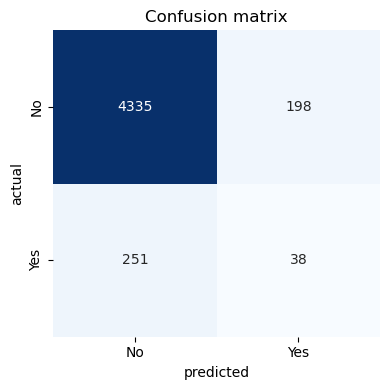

In [12]:
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, 
            annot=True, 
            cbar=False,
            fmt="d",
            cmap="Blues",
            xticklabels=["No", "Yes"],
            yticklabels=["No", "Yes"])
plt.title("Confusion matrix")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.tight_layout()

The fraction of people predicted to make a purchase who do actually make a
purchase (i.e., the _precision_) is $ 16.1\% $ when using a $ 20\% $ threshold.

In [13]:
fp, tp = conf_matrix[:, 1]
precision = tp / (fp + tp)
print(precision)

0.16101694915254236


For comparison, using a $ 50\% $ threshold to predict purchases, the precision improves to $ 25\% $:

In [14]:
conf_matrix = confusion_matrix(y_test, test_pred)
fp_50, tp_50 = conf_matrix[:, 1]
precision_50 = tp_50 / (fp_50 + tp_50)
print(precision_50)

0.25


Now let's fit a logistic regression and KNN models, and compare them to boosting. We begin
with the following function to evaluate each model's performance:

In [15]:
def get_metrics(model, X_test, y_test, threshold=0.2):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob > threshold).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = model.score(X_test, y_test)
    error_rate = 1 - accuracy
    precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
    return error_rate, precision, conf_matrix

We begin by fitting the LR model and evaluating its performance:

In [22]:
lr = LogisticRegression(max_iter=1_000, random_state=0)
lr.fit(X_train, y_train)
lr_error_rate, lr_precision, lr_conf_matrix = \
    get_metrics(lr, X_test, y_test, threshold=0.2)

print(f"Test error rate for logistic regression: {lr_error_rate:.4f}")
print(f"Precision for logistic regression: {lr_precision:.4f}")
print(f"\nTest error rate for the boosting model: {test_error_rate:.4f}")
print(f"Precision for the boosting model: {precision:.4f}")

Test error rate for logistic regression: 0.0655
Precision for logistic regression: 0.1777

Test error rate for the boosting model: 0.0931
Precision for the boosting model: 0.1515


In summary, logistic regression yields both a better error rate and a better precision than the boosting model 
when a threshold of $ 20\% $ is used for both in predicting a purchase.

In [16]:
K_values = list(range(1, 41, 2))
knn_results = []

for K in K_values:
    knn = KNeighborsClassifier(n_neighbors=K)
    knn.fit(X_train, y_train)
    error, precision, conf = get_metrics(knn, X_test, y_test)
    knn_results.append({
        "K": K,
        "error_rate": error,
        "precision": precision,
        "model": knn,
        "conf_matrix": conf
    })

# Find the best KNN model based on error rate:
best_index = np.argmin([result["error_rate"] for result in knn_results])
best_K = K_values[best_index]
best_knn_model = knn_results[best_index]["model"]
best_knn_error = knn_results[best_index]["error_rate"]
best_knn_precision = knn_results[best_index]["precision"]
best_knn_conf = knn_results[best_index]["conf_matrix"]

In [17]:
print(f"\nBest K value: {best_K}")
print(f"Test error rate for KNN-{best_K}: {best_knn_error:.4f}")
print(f"Precision for KNN-{best_K}: {best_knn_precision:.4f}")


Best K value: 13
Test error rate for KNN-13: 0.0599
Precision for KNN-13: 0.1514


We conclude that KNN yields the best error rate (though not by much) and has almost exactly the same precision as the boosting model, which is worse than that of logistic regression.